<a href="https://colab.research.google.com/github/T-Sawao/diveintocode-ml/blob/master/week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# week4-work 信用情報の学習

# 2.信用情報

Kaggleの Home Credit Default Risk コンペティションの学習および推定を行います。

Home Credit Default Risk | Kaggle  
https://www.kaggle.com/c/home-credit-default-risk

## 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。

### 1.1.1（解答）何を学習し、何を予測するのか

多くの顧客情報の中から有用なデータを使用して、顧客にローンの貸し出しが出来るかを予測する。

### 1.2.1（解答）どのようなファイルを作りKaggleに提出するか

ローンの貸し出しが可能な顧客の特徴を示したデータを使い、高い水準で貸し出しの可否を判断するファイルを作成。

### 1.3.1（解答）提出されたものはどういった指標値で評価されるのか

予測された確率から実際にローンを貸し出せる顧客の割合と、実際にはローンを貸し出せない顧客を貸し出せる顧客と推測した割合のROC曲線で評価される。  
正しくローン可能な顧客を割り出している指標値で評価される。

### 1.3.2（予備知識）ROC曲線 

2値分類で一般的に利用されているパフォーマンスを計測するための可視化手法です。　　
ROCは推測曲線と呼ばれ縦軸にTPR(True Positive Rate)、横軸にFPR(False Positive Rate) の割合をプロットしたものです。 AUC(Area Under the Curve) はその曲線の下部分の面のことで、AUC の面積が大きいほど一般的に機械学習の性能が良い事を意味します。面積が大きいということはすなわち機械学習モデルがNegative と推測すべきものを間違えてPositive と推測している傾向が少なく、Positive と推測すべきものをしっかりとPositive と推測できている状態です。

参考資料　https://qiita.com/TsutomuNakamura/items/ef963381e5d2768791d4

### 1.4.1（準備）

In [1]:
# 基本ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
sns.set()
import warnings
warnings.simplefilter('ignore')

In [2]:
# 訓練、検証データの読み込み
app_test= pd.read_csv("sample_dataset/home-credit-default-risk/application_test.csv")
app_train = pd.read_csv("sample_dataset/home-credit-default-risk/application_train.csv")

In [3]:
# 欠損値
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : "欠損数", 1 : "欠損率"})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        "欠損率", ascending=False).round(1)
    
    print(f"欠損している項目は{df.shape[1]}column中、{mis_val_table_ren_columns.shape[0]}columnsです。")
    return mis_val_table_ren_columns

In [4]:
# 欠損値出力
missing_values = missing_values_table(app_train)
missing_values.head(20)

欠損している項目は122column中、67columnsです。


,欠損数,欠損率
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [5]:
# 列ごとのデータ型
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [6]:
# 列ごとのデータの種類
app_train.select_dtypes("object").apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### 1.5.1（予備知識） エンコーディング  
参考資料 https://gotutiyan.hatenablog.com/entry/2020/09/08/122621

In [7]:
# ラベルエンコード（列数を増やさず、値を数字に変換する手法）

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

for col in app_train:
    # 値がオブジェクト型の時を条件指定。
    if app_train[col].dtype == "object":
        # カテゴリ数が２以下の条件指定。
        if len(list(app_train[col].unique())) <= 2:
            # 訓練データで学習を行う。
            le.fit(app_train[col])
            # 訓練、検証データ共に変換する。
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1
print(f"{le_count}columnsをエンコードしました。")

3columnsをエンコードしました。


In [8]:
# one_hotエンコード (値は0と１のみ、列数をカテゴリ数分用意する手法)

app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print(f"訓練データは: {app_train.shape} 検証データは: {app_test.shape}")

訓練データは: (307511, 243) 検証データは: (48744, 239)


### 1.6.1（予備知識）データの桁数を揃える  
pandas.DataFrame.align   
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.align.html

In [9]:
# ターゲットとIDを分断し保管。
train_labels = app_train['TARGET']
train_id = app_train["SK_ID_CURR"]
test_id = app_train["SK_ID_CURR"]

# A(app_train)とB(app_test)をjoin(両方含む)値に変換。
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 239)


### 1.7.1（予備知識）欠損値を埋める 

In [10]:
# 元データを残す
train1 = app_train.copy()
test1 = app_test.copy()

# 特微量リスト
features = list(app_train.columns)

# 欠損値を中央値で埋める
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
imputer.fit(train1)
train1 = imputer.transform(train1)
test1 = imputer.transform(test1)

### 1.8.1（予備知識）正規化

In [11]:
# 最小値0、最大値1に正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train1)
train1 = scaler.transform(train1)
test1 = scaler.transform(test1)

print('訓練データの数: ', train1.shape)
print('検証データの数: ', test1.shape)

訓練データの数:  (307511, 239)
検証データの数:  (48744, 239)


# 3.ベースラインモデルの作成

まずは単純な方法による ベースラインモデルを作成します。精度の基準となるモデルです。  
精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。

## 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。  
検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

### 2.1.1 (予備知識） Filter Methodでの解析
参考資料 https://qiita.com/shimopino/items/5fee7504c7acf044a521

### 2.2.1（解答）分析と前処理

In [12]:
# idも正規化で崩れたので削除
train_id = pd.DataFrame(train_id)
train_df = pd.DataFrame(train1)
train_df.columns = features
train_df = train_df.drop(columns ="SK_ID_CURR")

In [13]:
# idを復元
train_df = pd.concat([train_id, train_df],axis=1)
train_df

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,0.0,0.0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100003,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100004,1.0,1.0,1.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0.0,1.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0.0,0.0,1.0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,0.0,0.0,0.0,0.001127,0.052360,0.101176,0.046016,0.446855,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
307507,456252,0.0,0.0,1.0,0.0,0.000396,0.056067,0.040505,0.046016,0.344429,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
307508,456253,0.0,0.0,1.0,0.0,0.001089,0.157969,0.110618,0.135802,0.065247,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
307509,456254,0.0,0.0,1.0,0.0,0.001243,0.081175,0.072499,0.069585,0.069553,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, train_labels, test_size=0.20, random_state=0)
print(f"特微量の訓練データ = {len(X_train)}  特微量の検証データ = {len(X_test)}")
print(f"正解ラベルの訓練データ = {len(y_train)} 正解ラベルの検証データ = {len(y_test)}")

特微量の訓練データ = 246008  特微量の検証データ = 61503
正解ラベルの訓練データ = 246008 正解ラベルの検証データ = 61503


In [15]:
# pd型に変換。
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

# idの保管
X_train_id = X_train["SK_ID_CURR"]
X_test_id = X_test["SK_ID_CURR"]

In [16]:
# 分散が0（すべて同じ値）のデータは削除
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0)
sel.fit(X_train_df)

# get_supportで保持するデータのみをTrue値、そうでないものはFalse値を返します
print(sum(sel.get_support()))

239


In [17]:
# # numpy の場合
# X_train = sel.transform(X_train)
# X_test = sel.transform(X_test)

# pandasのままの場合
X_train_df = X_train_df.loc[:, sel.get_support()]
X_test_df = X_test_df.loc[:, sel.get_support()]

In [18]:
# 分散がほぼ0のデータは削除
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_df)

print(sum(sel.get_support()))

36


In [19]:
# # numpy の場合
# X_train = sel.transform(X_train)
# X_test = sel.transform(X_test)

# pandasのままの場合
X_train_df = X_train_df.loc[:, sel.get_support()]
X_test_df = X_test_df.loc[:, sel.get_support()]

In [20]:
# 特徴量の相関係数にしきい値を設定して該当しないものを削除

threshold = 0.8

feat_corr = set()
corr_matrix = X_train_df.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            feat_name = corr_matrix.columns[i]
            feat_corr.add(feat_name)

print(len(set(feat_corr)))

X_train_df.drop(labels=feat_corr, axis='columns', inplace=True)
X_test_df.drop(labels=feat_corr, axis='columns', inplace=True)

print(len(X_train_df.columns))

7
29


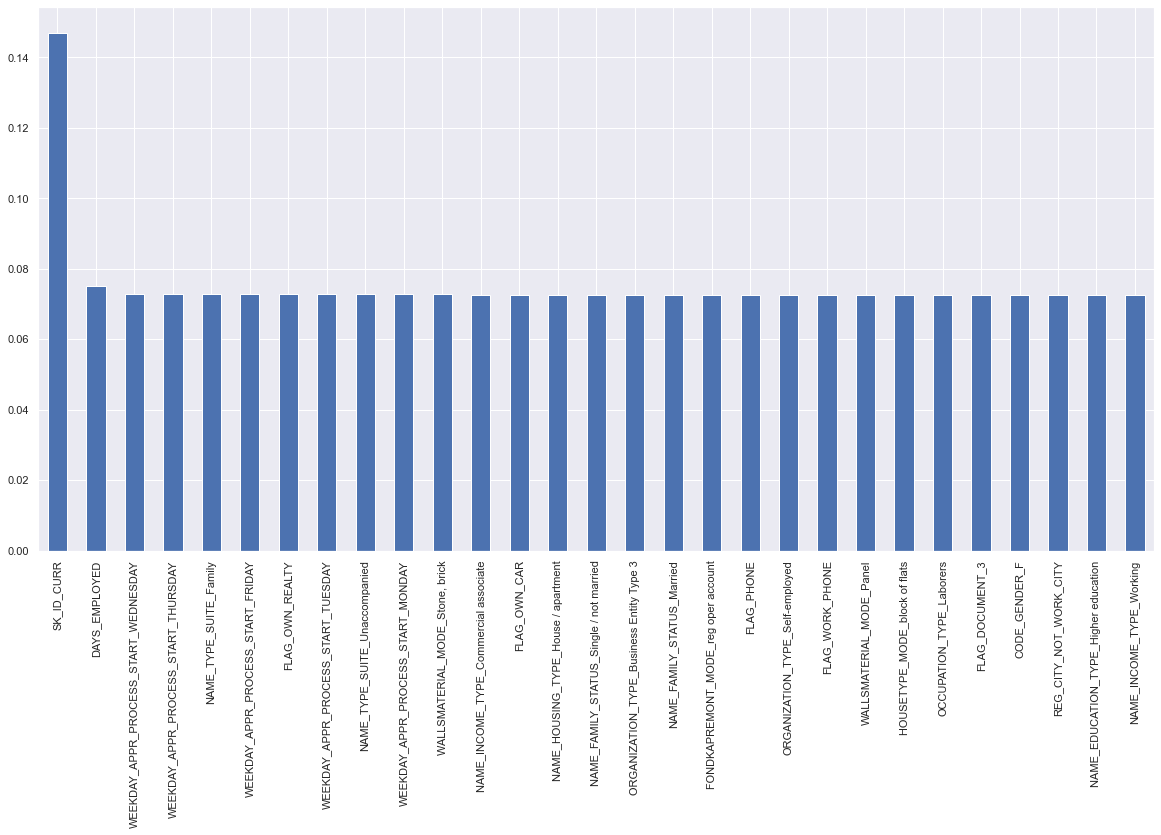

In [21]:
from sklearn import tree
from sklearn.metrics import mean_squared_error, roc_auc_score

MSE_features = []
for feature in X_train_df.columns:
    clf = tree.DecisionTreeRegressor()
    clf.fit(X_train_df[feature].to_frame(), y_train)
    y_pred = clf.predict(X_test[feature].to_frame())
    MSE_features.append(mean_squared_error(y_test, y_pred))

MSE_series = pd.Series(MSE_features)
MSE_series.index = X_train_df.columns
MSE_series.sort_values(ascending=False).plot(kind='bar', figsize=(20, 10))

In [22]:
Xy_train = pd.concat([X_train_df, y_train], axis=1)

Xy_heatmap = Xy_train.corr()["TARGET"].sort_values()
print(f"ターゲットと相関関係が強い上位10位\n{Xy_heatmap.head(15)}")

ターゲットと相関関係が強い上位10位
NAME_EDUCATION_TYPE_Higher education    -0.057033
CODE_GENDER_F                           -0.055213
DAYS_EMPLOYED                           -0.044862
HOUSETYPE_MODE_block of flats           -0.040627
WALLSMATERIAL_MODE_Panel                -0.033045
NAME_HOUSING_TYPE_House / apartment     -0.030317
NAME_FAMILY_STATUS_Married              -0.025610
FLAG_PHONE                              -0.023610
FLAG_OWN_CAR                            -0.022705
FONDKAPREMONT_MODE_reg oper account     -0.022417
WALLSMATERIAL_MODE_Stone, brick         -0.012857
NAME_INCOME_TYPE_Commercial associate   -0.010355
NAME_TYPE_SUITE_Family                  -0.009160
FLAG_OWN_REALTY                         -0.006532
WEEKDAY_APPR_PROCESS_START_MONDAY       -0.004670
Name: TARGET, dtype: float64


In [23]:
X_train_pk = Xy_train[["NAME_EDUCATION_TYPE_Higher education", "CODE_GENDER_F","DAYS_EMPLOYED",
                    "HOUSETYPE_MODE_block of flats","WALLSMATERIAL_MODE_Panel","NAME_HOUSING_TYPE_House / apartment"]]

X_test_pk = X_test[["NAME_EDUCATION_TYPE_Higher education", "CODE_GENDER_F","DAYS_EMPLOYED",
                 "HOUSETYPE_MODE_block of flats","WALLSMATERIAL_MODE_Panel","NAME_HOUSING_TYPE_House / apartment"]]

### 2.2.2（解答）学習と評価

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ランダムフォレスト
rfc = RandomForestClassifier(max_depth=2)

# 学習
rfc.fit(X_train_pk, y_train)

# 予測
rfc_pred = rfc.predict(X_test_pk)

# 評価
print("score", rfc.score(X_test_pk, y_test))
print('confusion matrix = \n', confusion_matrix(y_test, rfc_pred))
print("Classification report\n", classification_report(y_test, rfc_pred))

score 0.9210607612636782
confusion matrix = 
 [[56648     0]
 [ 4855     0]]
Classification report
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56648
           1       0.00      0.00      0.00      4855

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



In [25]:
submit = X_test[["SK_ID_CURR"]]
submit['TARGET'] = rfc_pred
# indexのリセット
submit.reset_index()
# indexの削除
submit = submit.reset_index(drop=True)
submit.head()

,SK_ID_CURR,TARGET
0,149741,0
1,363290,0
2,436006,0
3,377703,0
4,188624,0


### 2.2.3（解答）ROCコード　
https://www.codexa.net/ml-evaluation-cls/

In [26]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

#テストデータがクラス1に属する確率を予測し、その確率からFPR、TPR、閾値を計算
rfc_proba = rfc.predict_proba(X_test_pk)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rfc_proba)

#FPR、TPR、閾値をデータフレームに格納して表示
fpr_tpr_thresholds_df = pd.DataFrame([fpr,tpr,thresholds])
fpr_tpr_thresholds_df.T.head()

,0,1,2
0,0.000000,0.000000,1.106784
1,0.009974,0.022657,0.106784
2,0.010839,0.025335,0.106386
3,0.010839,0.025541,0.105608
4,0.010909,0.025541,0.105493


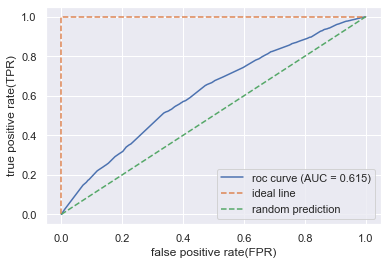

In [27]:
#ROC曲線を描き、AUCを算出
plt.plot(fpr,tpr,label='roc curve (AUC = %0.3f)' % auc(fpr,tpr))
plt.plot([0,0,1], [0,1,1], linestyle='--', label='ideal line')
plt.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
plt.legend()
plt.xlabel('false positive rate(FPR)')
plt.ylabel('true positive rate(TPR)')
plt.show()

### 2.2.4（予備知識） PR曲線  
https://aidemy.net/courses/2010/exercises/HyGxFhIiUxG#:~:text=PR%E6%9B%B2%E7%B7%9A%20%E3%81%A8%E3%81%AF%E3%80%81%E6%A8%AA,%E3%81%99%E3%82%8B%E3%81%93%E3%81%A8%E3%82%92%E8%80%83%E3%81%88%E3%81%BE%E3%81%99%E3%80%82

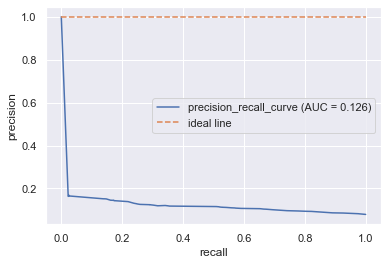

In [28]:
#PR曲線を描き、AUCを算出
precision, recall, thresholds = precision_recall_curve(y_test, rfc_proba)
 
plt.plot(recall, precision, label=f'precision_recall_curve (AUC = {auc(recall,precision):0.3f})')
plt.plot([0,1], [1,1], linestyle='--', label='ideal line')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

## 【問題3】テストデータに対する推定
テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。  
正しく提出が行えていれば、精度は低くても構いません。

## 3.1.1（解答）

In [29]:
test_df = pd.DataFrame(test1)
test_df.columns = features 

In [30]:
train_pk = train_df[["NAME_EDUCATION_TYPE_Higher education", "CODE_GENDER_F", "DAYS_EMPLOYED",
                    "HOUSETYPE_MODE_block of flats", "WALLSMATERIAL_MODE_Panel", "NAME_HOUSING_TYPE_House / apartment"]]

test_pk = test_df[["NAME_EDUCATION_TYPE_Higher education", "CODE_GENDER_F", "DAYS_EMPLOYED",
                    "HOUSETYPE_MODE_block of flats", "WALLSMATERIAL_MODE_Panel", "NAME_HOUSING_TYPE_House / apartment"]]

In [31]:
# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=2)
rfc.fit(train_pk, train_labels)
rfc_pred = rfc.predict_proba(test_pk)[:, 1]

In [32]:
submit = app_test[["SK_ID_CURR"]]
submit['TARGET'] = rfc_pred
# indexのリセット
# submit.reset_index()
# # indexの削除
# submit = submit.reset_index(drop=True)
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.062205
1,100005,0.090869
2,100013,0.065895
3,100028,0.080539
4,100038,0.100351


In [33]:
submit.to_csv('rfc_baseline.csv', index = False)

kaggleへ提出し、スコアは『0.61340』でした。

# 4.特徴量エンジニアリング  
ベースラインモデルを元に、入力する特徴量に様々な工夫を行い精度を向上させていきます。

## 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。  
- どの特徴量を使うか  
- どう前処理をするか

何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。  
精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

### 4.0.0 （準備）この章以降、データ数が多く演算時間がかかるためデータ数を十分の一に調整

In [34]:
x_train_pk = X_train_pk[:24000]
x_test_pk = X_test_pk[:6100]
y_train_pk = y_train[:24000]
y_test_pk = y_test[:6100]
print(x_train_pk.shape)

(24000, 6)


In [35]:
a = np.array(y_train)
print(np.count_nonzero(a==1))

19970


### 4.1.1（解答）ロジスティック回帰による分類　特微量は3章の６個

In [36]:
#ロジスティック回帰モデルのインスタンスを作成し、訓練データで学習
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=50, random_state=0)
lr.fit(x_train_pk, y_train_pk)
lr_pred = lr.predict(x_test_pk)

# 評価
print("score", lr.score(x_test_pk, y_test_pk))
print('confusion matrix = \n', confusion_matrix(y_test_pk, lr_pred))
print("Classification report\n", classification_report(y_test_pk, lr_pred))

score 0.9249180327868852
confusion matrix = 
 [[5642    0]
 [ 458    0]]
Classification report
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      5642
           1       0.00      0.00      0.00       458

    accuracy                           0.92      6100
   macro avg       0.46      0.50      0.48      6100
weighted avg       0.86      0.92      0.89      6100



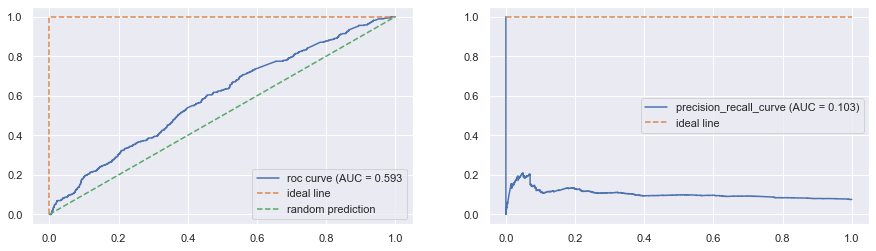

In [37]:
# テストデータがクラス1に属する確率を予測し、その確率からFPR、TPR、閾値を計算
lr_proba = lr.predict_proba(x_test_pk)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_pk, lr_proba)
precision, recall, thresholds = precision_recall_curve(y_test_pk, lr_proba)

# ROC曲線、PR曲線のプロット
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#ROC曲線を描き、AUCを算出
ax1.plot(fpr,tpr,label=f'roc curve (AUC = {auc(fpr,tpr):0.3f}')
ax1.plot([0,0,1], [0,1,1], linestyle='--', label='ideal line')
ax1.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
ax1.legend()

#PR曲線を描き、AUCを算出
ax2.plot(recall, precision, label=f'precision_recall_curve (AUC = {auc(recall,precision):0.3f})')
ax2.plot([0,1], [1,1], linestyle='--', label='ideal line')
ax2.legend()

### 4.1.2（解答）SVMによる分類　特徴量は３章の６個

In [38]:
# SVMを指定
from sklearn.svm import SVC

svc = SVC(kernel='rbf', C=1.0, probability=True)
svc.fit(x_train_pk, y_train_pk)
svc_pred = svc.predict(x_test_pk)

#評価
print("score", svc.score(x_test_pk, y_test_pk))
print('confusion matrix = \n', confusion_matrix(y_test_pk, svc_pred))
print("Classification report\n", classification_report(y_test_pk, svc_pred))

score 0.9249180327868852
confusion matrix = 
 [[5642    0]
 [ 458    0]]
Classification report
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      5642
           1       0.00      0.00      0.00       458

    accuracy                           0.92      6100
   macro avg       0.46      0.50      0.48      6100
weighted avg       0.86      0.92      0.89      6100



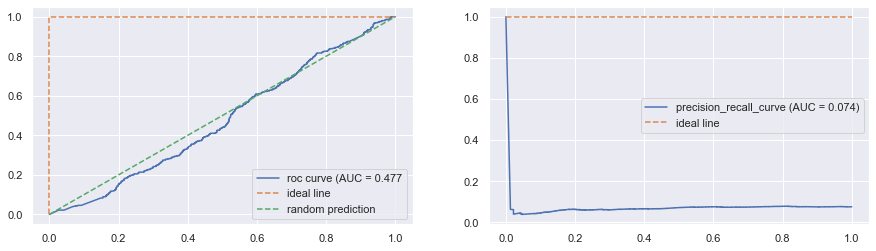

In [39]:
# テストデータがクラス1に属する確率を予測し、その確率からFPR、TPR、閾値を計算
svc_proba = svc.predict_proba(x_test_pk)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_pk, svc_proba)
precision, recall, thresholds = precision_recall_curve(y_test_pk, svc_proba)

# ROC曲線、PR曲線のプロット
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#ROC曲線を描き、AUCを算出
ax1.plot(fpr,tpr,label=f'roc curve (AUC = {auc(fpr,tpr):0.3f}')
ax1.plot([0,0,1], [0,1,1], linestyle='--', label='ideal line')
ax1.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
ax1.legend()

#PR曲線を描き、AUCを算出
ax2.plot(recall, precision, label=f'precision_recall_curve (AUC = {auc(recall,precision):0.3f})')
ax2.plot([0,1], [1,1], linestyle='--', label='ideal line')
ax2.legend()

### 4.1.3（解答）K近傍法による分類　特徴量は３章の６個

In [40]:
# k近傍法を指定
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=5) 
knc.fit(x_train_pk, y_train_pk)
knc_pred = knc.predict(x_test_pk)

#評価
print("score", knc.score(x_test_pk, y_test_pk))
print('confusion matrix = \n', confusion_matrix(y_test_pk, knc_pred))
print("Classification report\n", classification_report(y_test_pk, knc_pred))

score 0.920327868852459
confusion matrix = 
 [[5610   32]
 [ 454    4]]
Classification report
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5642
           1       0.11      0.01      0.02       458

    accuracy                           0.92      6100
   macro avg       0.52      0.50      0.49      6100
weighted avg       0.86      0.92      0.89      6100



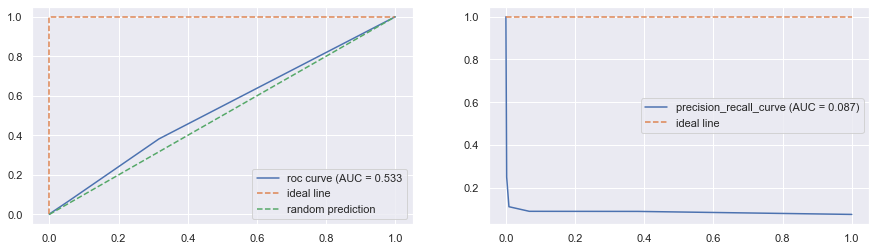

In [41]:
# テストデータがクラス1に属する確率を予測し、その確率からFPR、TPR、閾値を計算
knc_proba = knc.predict_proba(x_test_pk)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_pk, knc_proba)
precision, recall, thresholds = precision_recall_curve(y_test_pk, knc_proba)

# ROC曲線、PR曲線のプロット
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#ROC曲線を描き、AUCを算出
ax1.plot(fpr,tpr,label=f'roc curve (AUC = {auc(fpr,tpr):0.3f}')
ax1.plot([0,0,1], [0,1,1], linestyle='--', label='ideal line')
ax1.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
ax1.legend()

#PR曲線を描き、AUCを算出
ax2.plot(recall, precision, label=f'precision_recall_curve (AUC = {auc(recall,precision):0.3f})')
ax2.plot([0,1], [1,1], linestyle='--', label='ideal line')
ax2.legend()

### 4.1.4（解答）ランダムフォレストによる分類　特徴量は３章の６個

In [42]:
# ランダムフォレスト
rfc1 = RandomForestClassifier(max_depth=2)
rfc1.fit(x_train_pk, y_train_pk)
rfc1_pred = rfc1.predict(x_test_pk)

# 評価
print("score", rfc1.score(x_test_pk, y_test_pk))
print('confusion matrix = \n', confusion_matrix(y_test_pk, rfc1_pred))
print("Classification report\n", classification_report(y_test_pk, rfc1_pred))

score 0.9249180327868852
confusion matrix = 
 [[5642    0]
 [ 458    0]]
Classification report
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      5642
           1       0.00      0.00      0.00       458

    accuracy                           0.92      6100
   macro avg       0.46      0.50      0.48      6100
weighted avg       0.86      0.92      0.89      6100



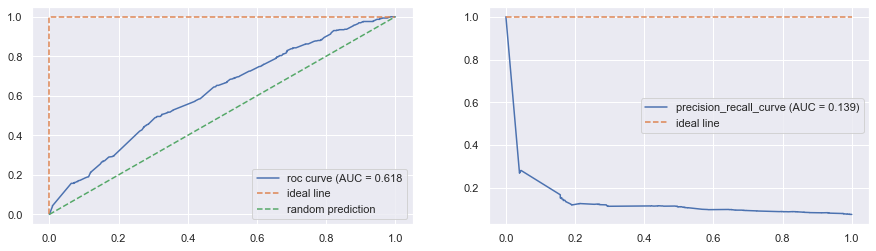

In [43]:
# テストデータがクラス1に属する確率を予測し、その確率からFPR、TPR、閾値を計算
rfc1_proba = rfc1.predict_proba(x_test_pk)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_pk, rfc1_proba)
precision, recall, thresholds = precision_recall_curve(y_test_pk, rfc1_proba)

# ROC曲線、PR曲線のプロット
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#ROC曲線を描き、AUCを算出
ax1.plot(fpr,tpr,label=f'roc curve (AUC = {auc(fpr,tpr):0.3f}')
ax1.plot([0,0,1], [0,1,1], linestyle='--', label='ideal line')
ax1.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
ax1.legend()

#PR曲線を描き、AUCを算出
ax2.plot(recall, precision, label=f'precision_recall_curve (AUC = {auc(recall,precision):0.3f})')
ax2.plot([0,1], [1,1], linestyle='--', label='ideal line')
ax2.legend()

ランダムフォレストがROC曲線、PR曲線ともに４つの分類器の中では評価が高い。  
K近傍法以外は全ての顧客にローンの貸し出しが可能と判断しているので、貸し出しNGを見分ける精度としては全て不十分。  
K近傍法は混合行列的に４つの貸し出しNGを見割れているが、貸し出し可能者を32名貸し出しNGとしている。  
今回は正しく貸し出ししている確率が良いモデルという条件なので、以降ロジスティクス回帰で特徴量検証を行う。  

### 4.2.1（準備）特微量数による比較

In [44]:
#  target相関で１番良いDAYS_EMPLOYEDのみのデータセットを作成
x_train_days = np.array(X_train[["DAYS_EMPLOYED"]]) 
x_test_days = np.array(X_test[["DAYS_EMPLOYED"]]) 
print(x_train_days.shape, x_test_days.shape)

(246008, 1) (61503, 1)


In [45]:
print(np.count_nonzero(y_test==0))

56648


### 4.2.2（解答）特微量数による比較 1個の場合

In [46]:
#ランダムフォレスト
rfc2 = RandomForestClassifier(max_depth=2).fit(x_train_days, y_train)
rfc2_pred = rfc2.predict(x_test_days)

# 評価
print("score", rfc2.score(x_test_days, y_test))
print('confusion matrix = \n', confusion_matrix(y_test, rfc2_pred))
print("Classification report\n", classification_report(y_test, rfc2_pred))

score 0.9210607612636782
confusion matrix = 
 [[56648     0]
 [ 4855     0]]
Classification report
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56648
           1       0.00      0.00      0.00      4855

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



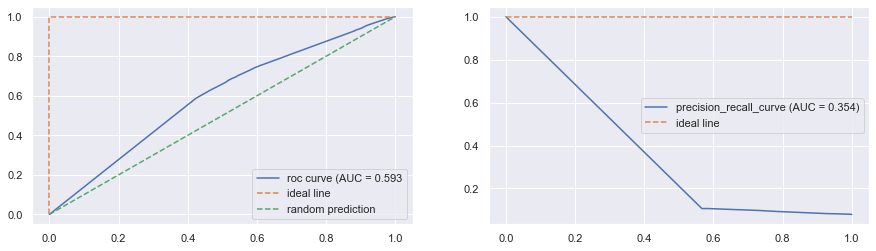

In [47]:
# テストデータがクラス1に属する確率を予測し、その確率からFPR、TPR、閾値を計算
rfc2_proba = rfc2.predict_proba(x_test_days)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rfc2_proba)
precision, recall, thresholds = precision_recall_curve(y_test, rfc2_proba)

# ROC曲線、PR曲線のプロット
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#ROC曲線を描き、AUCを算出
ax1.plot(fpr,tpr,label=f'roc curve (AUC = {auc(fpr,tpr):0.3f}')
ax1.plot([0,0,1], [0,1,1], linestyle='--', label='ideal line')
ax1.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
ax1.legend()

#PR曲線を描き、AUCを算出
ax2.plot(recall, precision, label=f'precision_recall_curve (AUC = {auc(recall,precision):0.3f})')
ax2.plot([0,1], [1,1], linestyle='--', label='ideal line')
ax2.legend()

### 4.2.2（解答）特微量数による比較（全特徴量239個）

In [48]:
#ランダムフォレスト
rfc3 = RandomForestClassifier(max_depth=2).fit(X_train, y_train)
rfc3_pred = rfc3.predict(X_test)

# 評価
print("score", rfc3.score(X_test, y_test))
print('confusion matrix = \n', confusion_matrix(y_test, rfc3_pred))
print("Classification report\n", classification_report(y_test, rfc3_pred))

score 0.9210607612636782
confusion matrix = 
 [[56648     0]
 [ 4855     0]]
Classification report
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56648
           1       0.00      0.00      0.00      4855

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



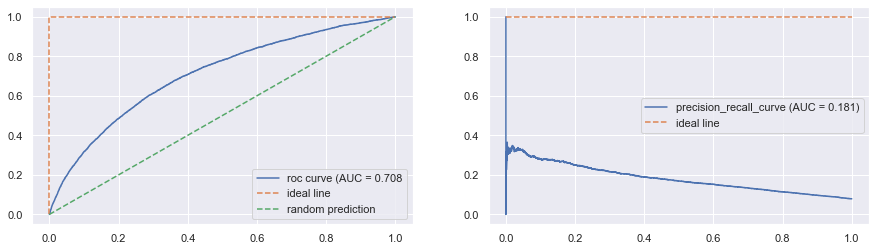

In [49]:
# テストデータがクラス1に属する確率を予測し、その確率からFPR、TPR、閾値を計算
rfc3_proba = rfc3.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rfc3_proba)
precision, recall, thresholds = precision_recall_curve(y_test, rfc3_proba)

# ROC曲線、PR曲線のプロット
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#ROC曲線を描き、AUCを算出
ax1.plot(fpr,tpr,label=f'roc curve (AUC = {auc(fpr,tpr):0.3f}')
ax1.plot([0,0,1], [0,1,1], linestyle='--', label='ideal line')
ax1.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
ax1.legend()

#PR曲線を描き、AUCを算出
ax2.plot(recall, precision, label=f'precision_recall_curve (AUC = {auc(recall,precision):0.3f})')
ax2.plot([0,1], [1,1], linestyle='--', label='ideal line')
ax2.legend()

特徴量は多いほど精度が高くなるという結果がでた。

### 4.3.1（予備知識）特徴量の厳選 LigthGBMでのFeature Importance

In [50]:
xtr2 = X_train.drop("SK_ID_CURR", axis=1)
xte2 = X_test.drop("SK_ID_CURR", axis=1)
type(xte2)

pandas.core.frame.DataFrame

In [51]:
import lightgbm as lgb 

# LightGBM in train&test dataset
lgb_train = lgb.Dataset(xtr2, y_train)
lgb_test = lgb.Dataset(xte2, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的 : 回帰  
        'metric': {'rmse'}, # 評価指標 : rsme(平均二乗誤差の平方根) 
}

# LightGBM fit
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_test, # 検証データの指定
                  )

[1]	valid_0's rmse: 0.26822
[2]	valid_0's rmse: 0.267059
[3]	valid_0's rmse: 0.266083
[4]	valid_0's rmse: 0.265292
[5]	valid_0's rmse: 0.264627
[6]	valid_0's rmse: 0.264091
[7]	valid_0's rmse: 0.263617
[8]	valid_0's rmse: 0.263184
[9]	valid_0's rmse: 0.262831
[10]	valid_0's rmse: 0.262557
[11]	valid_0's rmse: 0.262283
[12]	valid_0's rmse: 0.262032
[13]	valid_0's rmse: 0.261811
[14]	valid_0's rmse: 0.261619
[15]	valid_0's rmse: 0.261458
[16]	valid_0's rmse: 0.261291
[17]	valid_0's rmse: 0.261144
[18]	valid_0's rmse: 0.260978
[19]	valid_0's rmse: 0.260824
[20]	valid_0's rmse: 0.260685
[21]	valid_0's rmse: 0.260549
[22]	valid_0's rmse: 0.260447
[23]	valid_0's rmse: 0.260365
[24]	valid_0's rmse: 0.260252
[25]	valid_0's rmse: 0.260148
[26]	valid_0's rmse: 0.260027
[27]	valid_0's rmse: 0.259939
[28]	valid_0's rmse: 0.259873
[29]	valid_0's rmse: 0.259796
[30]	valid_0's rmse: 0.259749
[31]	valid_0's rmse: 0.259695
[32]	valid_0's rmse: 0.259623
[33]	valid_0's rmse: 0.259573
[34]	valid_0's rmse:

In [52]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(xtr2.columns)       # 特徴量名のリスト(目的変数CRIM以外)
# 特徴量重要度の算出方法 'gain'(推奨) : トレーニングデータの損失の減少量を評価
f_importance = np.array(model.feature_importance(importance_type='gain')) # 特徴量重要度の算出 //
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
df_importance.head(15)

,feature,importance
32,EXT_SOURCE_3,0.255126
31,EXT_SOURCE_2,0.244206
30,EXT_SOURCE_1,0.078123
9,DAYS_BIRTH,0.045985
5,AMT_CREDIT,0.032172
6,AMT_ANNUITY,0.031301
7,AMT_GOODS_PRICE,0.029407
10,DAYS_EMPLOYED,0.028323
12,DAYS_ID_PUBLISH,0.017449
80,DAYS_LAST_PHONE_CHANGE,0.014684


In [53]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df):
    n_feature = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_feature), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.yticks(np.arange(n_feature), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

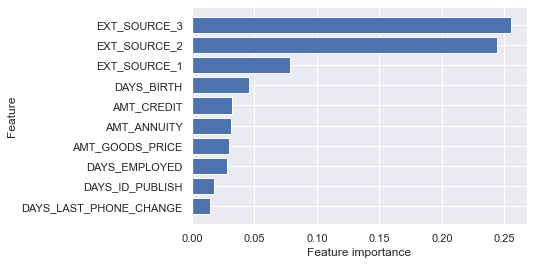

In [54]:
# 特徴量重要度の可視化
n_display = 10 # 上位10個に制限
plot_feature_importance(df_importance.iloc[:n_display,:])

### 4.3.2（解答）検証

In [55]:
train3 = xtr2[["EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1"]]
test3 = xte2[["EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1"]]

In [56]:
#ランダムフォレスト
rfc5 = RandomForestClassifier(max_depth=2).fit(train3, y_train)
rfc5_pred = rfc5.predict(test3)

# 評価
print("score", rfc5.score(test3, y_test))
print('confusion matrix = \n', confusion_matrix(y_test, rfc5_pred))
print("Classification report\n", classification_report(y_test, rfc5_pred))

score 0.9210607612636782
confusion matrix = 
 [[56648     0]
 [ 4855     0]]
Classification report
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56648
           1       0.00      0.00      0.00      4855

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



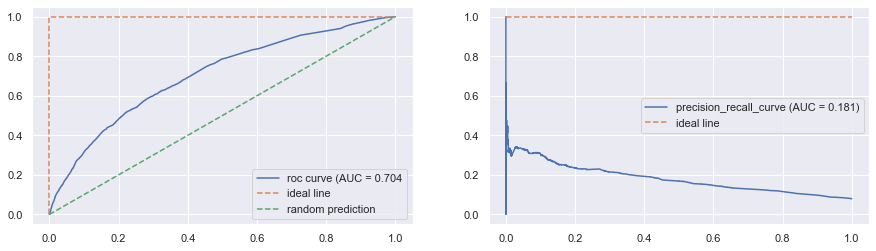

In [57]:
# テストデータがクラス1に属する確率を予測し、その確率からFPR、TPR、閾値を計算
rfc5_proba = rfc5.predict_proba(test3)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rfc5_proba)
precision, recall, thresholds = precision_recall_curve(y_test, rfc5_proba)

# ROC曲線、PR曲線のプロット
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#ROC曲線を描き、AUCを算出
ax1.plot(fpr,tpr,label=f'roc curve (AUC = {auc(fpr,tpr):0.3f}')
ax1.plot([0,0,1], [0,1,1], linestyle='--', label='ideal line')
ax1.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
ax1.legend()

#PR曲線を描き、AUCを算出
ax2.plot(recall, precision, label=f'precision_recall_curve (AUC = {auc(recall,precision):0.3f})')
ax2.plot([0,1], [1,1], linestyle='--', label='ideal line')
ax2.legend()

In [58]:
train4 = xtr2[["EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1","DAYS_BIRTH"]]
test4 = xte2[["EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1","DAYS_BIRTH"]]

#ランダムフォレスト
rfc6 = RandomForestClassifier(max_depth=2).fit(train4, y_train)
rfc6_pred = rfc6.predict(test4)

# 評価
print("score", rfc6.score(test4, y_test))
print('confusion matrix = \n', confusion_matrix(y_test, rfc6_pred))
print("Classification report\n", classification_report(y_test, rfc6_pred))

score 0.9210607612636782
confusion matrix = 
 [[56648     0]
 [ 4855     0]]
Classification report
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56648
           1       0.00      0.00      0.00      4855

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



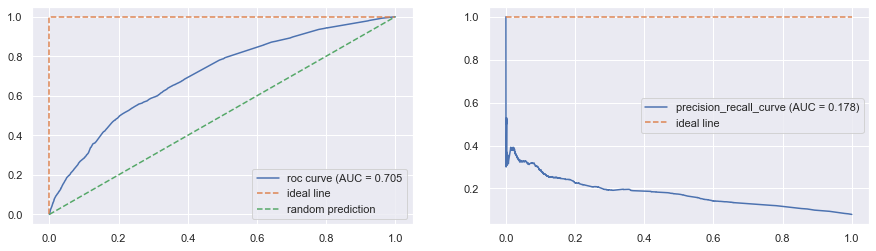

In [59]:
# テストデータがクラス1に属する確率を予測し、その確率からFPR、TPR、閾値を計算
rfc6_proba = rfc6.predict_proba(test4)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rfc6_proba)
precision, recall, thresholds = precision_recall_curve(y_test, rfc6_proba)

# ROC曲線、PR曲線のプロット
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#ROC曲線を描き、AUCを算出
ax1.plot(fpr,tpr,label=f'roc curve (AUC = {auc(fpr,tpr):0.3f}')
ax1.plot([0,0,1], [0,1,1], linestyle='--', label='ideal line')
ax1.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
ax1.legend()

#PR曲線を描き、AUCを算出
ax2.plot(recall, precision, label=f'precision_recall_curve (AUC = {auc(recall,precision):0.3f})')
ax2.plot([0,1], [1,1], linestyle='--', label='ideal line')
ax2.legend()

In [60]:
train5 = xtr2[["EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1", "DAYS_BIRTH", "AMT_CREDIT"]]
test5 = xte2[["EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1", "DAYS_BIRTH", "AMT_CREDIT"]]

#ランダムフォレスト
rfc7 = RandomForestClassifier(max_depth=2).fit(train5, y_train)
rfc7_pred = rfc7.predict(test5)

# 評価
print("score", rfc7.score(test5, y_test))
print('confusion matrix = \n', confusion_matrix(y_test, rfc7_pred))
print("Classification report\n", classification_report(y_test, rfc7_pred))

score 0.9210607612636782
confusion matrix = 
 [[56648     0]
 [ 4855     0]]
Classification report
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56648
           1       0.00      0.00      0.00      4855

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



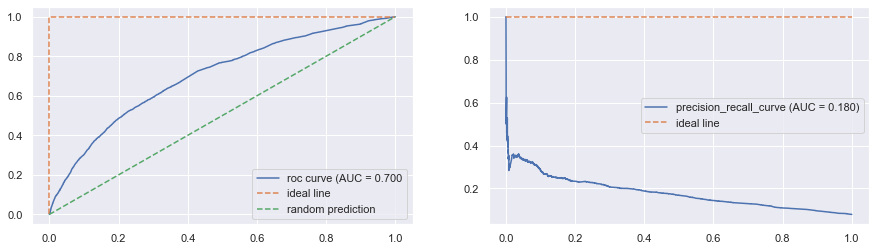

In [61]:
# テストデータがクラス1に属する確率を予測し、その確率からFPR、TPR、閾値を計算
rfc7_proba = rfc7.predict_proba(test5)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rfc7_proba)
precision, recall, thresholds = precision_recall_curve(y_test, rfc7_proba)

# ROC曲線、PR曲線のプロット
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#ROC曲線を描き、AUCを算出
ax1.plot(fpr,tpr,label=f'roc curve (AUC = {auc(fpr,tpr):0.3f}')
ax1.plot([0,0,1], [0,1,1], linestyle='--', label='ideal line')
ax1.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
ax1.legend()

#PR曲線を描き、AUCを算出
ax2.plot(recall, precision, label=f'precision_recall_curve (AUC = {auc(recall,precision):0.3f})')
ax2.plot([0,1], [1,1], linestyle='--', label='ideal line')
ax2.legend()

In [62]:
train1 = xtr2[["EXT_SOURCE_3"]]
test1 = xte2[["EXT_SOURCE_3"]]

#ランダムフォレスト
rfc8 = RandomForestClassifier(max_depth=2).fit(train1, y_train)
rfc8_pred = rfc8.predict(test1)

# 評価
print("score", rfc8.score(test1, y_test))
print('confusion matrix = \n', confusion_matrix(y_test, rfc8_pred))
print("Classification report\n", classification_report(y_test, rfc8_pred))

score 0.9210607612636782
confusion matrix = 
 [[56648     0]
 [ 4855     0]]
Classification report
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56648
           1       0.00      0.00      0.00      4855

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



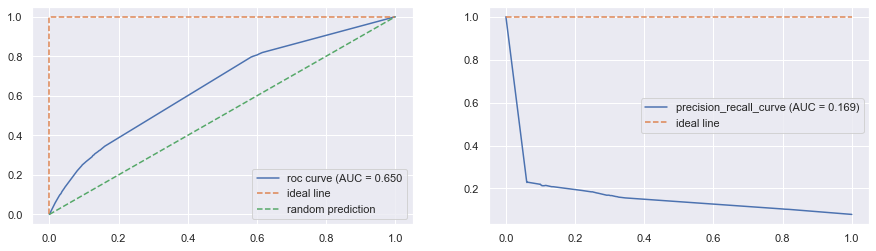

In [63]:
# テストデータがクラス1に属する確率を予測し、その確率からFPR、TPR、閾値を計算
rfc8_proba = rfc8.predict_proba(test1)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rfc8_proba)
precision, recall, thresholds = precision_recall_curve(y_test, rfc8_proba)

# ROC曲線、PR曲線のプロット
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#ROC曲線を描き、AUCを算出
ax1.plot(fpr,tpr,label=f'roc curve (AUC = {auc(fpr,tpr):0.3f}')
ax1.plot([0,0,1], [0,1,1], linestyle='--', label='ideal line')
ax1.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
ax1.legend()

#PR曲線を描き、AUCを算出
ax2.plot(recall, precision, label=f'precision_recall_curve (AUC = {auc(recall,precision):0.3f})')
ax2.plot([0,1], [1,1], linestyle='--', label='ideal line')
ax2.legend()

### 4.3.3（解答）結果まとめ

特徴量が４つの時にROC曲線、PR曲線で最大値を示した。  
全特徴量での検証と、LightGBMが進める特徴量２種でほとんど差が無いことからも"EXT_SOURCE_3", "EXT_SOURCE_2"が
ローン貸し出しの可否の判断基準で最重要な要素であると考えられる。

## 【問題5】最終的なモデルの選定
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

### 5.1.1（解答）最終モデルでの学習

In [64]:
# 学習データ
print("train",train_df.shape,  "train_labels", train_labels.shape)

# 本番検証データ
print("test", test_df.shape)

train (307511, 239) train_labels (307511,)
test (48744, 239)


In [65]:
train = train_df[["EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1","DAYS_BIRTH"]]
test = test_df[["EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1","DAYS_BIRTH"]]

#ランダムフォレスト
rfc9 = RandomForestClassifier(max_depth=2).fit(train, train_labels)
rfc9_pred = rfc9.predict(test)
rfc9_proba= rfc9.predict_proba(test)[:, 1]

In [66]:
submit = app_test[["SK_ID_CURR"]]
submit['TARGET'] = rfc9_proba
# indexのリセット
# submit.reset_index()
# # indexの削除
# submit = submit.reset_index(drop=True)
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.117487
1,100005,0.100390
2,100013,0.053299
3,100028,0.052045
4,100038,0.082983


In [67]:
submit.to_csv('rfc9_baseline.csv', index = False)

### 5.2.1（解答）まとめ

LightGBMで特徴量を厳選した４つでkaggleに提出しスコア　0.69026　でした。  
機械学習を使わずにFilter Methodという手法で厳選した特徴量６つ時のスコアが0.61340に対して、  
約0.08スコアが伸ばせたことからもLightGBMの有用性を確認できました。  
今回ハイパーパラメータの調整は一切行ってないので、まだまだ伸びしろはあるので、  
今後はハイパーパラメータの調整にも挑戦して行きたい。